# Pyspark Streaming e Architettura Medallion

In questo notebook verranno mostrati Spark Structured Streaming, transazioni ACID con Delta Lake, 
Architettura Medallion (Bronze/Silver/Gold), gestione dati semi-strutturati (Avro) e generazione di insight aziendali.

## Structured Streaming

Spark Structured Streaming e un motore di elaborazione stream scalabile e fault-tolerant 
costruito sul motore Spark SQL. Invece di elaborare i dati record per record, utilizza un 
approccio a **micro-batch**: i dati in arrivo vengono accumulati in un intervallo di tempo 
configurabile (trigger interval) e poi elaborati come un piccolo batch usando la stessa API 
DataFrame/SQL usata per il processing batch. Questo modello unificato permette di riutilizzare 
le stesse trasformazioni, join e aggregazioni scritte per pipeline batch anche sullo streaming.

L'astrazione centrale e una **tabella di input illimitata** che cresce con l'arrivo di nuovi dati. 
A ogni trigger interval, nuove righe vengono aggiunte a questa tabella concettuale e il motore 
calcola incrementalmente il risultato. Lo sviluppatore non deve gestire offset, retry o stato -- 
Spark gestisce tutto tramite il **checkpointing**, che salva lo stato di avanzamento su storage 
durevole per garantire il recupero da errori senza perdita o duplicazione di dati.

Tre **modalita di output** controllano come vengono scritti i risultati:
- **Append**: solo le nuove righe dall'ultimo trigger vengono scritte (adatto per sink insert-only)
- **Update**: solo le righe modificate dall'ultimo trigger vengono scritte (efficiente per aggregazioni)
- **Complete**: l'intera tabella risultante viene riscritta a ogni trigger (utile per piccole tabelle di aggregazione)

In questo notebook utilizziamo **file Avro su MinIO** come sorgente streaming. Impostando 
`maxFilesPerTrigger`, Spark preleva un numero limitato di nuovi file per micro-batch, simulando 
un flusso dati continuo da un dataset partizionato esistente.

## Architettura Medallion

L'Architettura Medallion e un design pattern per i dati ampiamente adottato nei moderni data lakehouse. 
Organizza i dati in tre livelli progressivi di qualita, ciascuno con una responsabilita chiara:

**Bronze Layer** - la zona di ingestione grezza. I dati atterrano qui esattamente come arrivano dalla 
sorgente, con trasformazioni minime o nulle. L'obiettivo e creare una copia durevole e immutabile dei dati 
grezzi in un formato affidabile (Delta Lake). Se qualcosa va storto a valle, il layer Bronze funge da 
unica fonte di verita per il riprocessamento.

**Silver Layer** - la zona di pulizia e arricchimento. Qui vengono applicate le regole di qualita dei dati: 
filtro dei null, validazione degli intervalli, deduplicazione, filtro per stato. I dati di riferimento 
(clienti, prodotti) vengono uniti tramite join per produrre un dataset denormalizzato e pronto per il 
business. Il layer Silver e quello da cui la maggior parte delle query analitiche dovrebbe leggere.

**Gold Layer** - la zona di aggregazione. Qui risiedono metriche pre-calcolate e riepiloghi 
dimensionali. Queste tabelle sono ottimizzate per il consumo da dashboard e reporting. Esempi includono 
vendite giornaliere per regione, breakdown per categoria e calcoli dei trend di crescita.

I vantaggi principali di questo approccio a livelli sono l'**isolamento** (un bug nella logica di 
arricchimento non corrompe i dati grezzi), la **riprocessabilita** (ogni livello puo essere ricostruito 
da quello sottostante) e i **gate di qualita progressivi** (ogni livello garantisce un livello di qualita 
dei dati superiore al precedente).

## Delta Lake per lo Streaming

Delta Lake aggiunge **garanzie transazionali ACID** ai data lake. Ogni scrittura -- che provenga da un 
job batch o da un micro-batch streaming -- e atomica: o tutte le righe del batch vengono committate, o 
nessuna. Questo elimina la corruzione da scritture parziali che puo verificarsi con file Parquet semplici 
su object storage.

In modalita streaming, Delta Lake offre due benefici aggiuntivi. Primo, lo **schema enforcement**: se i 
dati in ingresso non corrispondono allo schema della tabella, la scrittura fallisce con un errore chiaro 
invece di corrompere silenziosamente la tabella. Secondo, il **versioning automatico**: ogni commit di 
micro-batch crea una nuova versione nel transaction log di Delta, abilitando query time-travel e piena 
tracciabilita dell'evoluzione dei dati nel tempo.

Delta Lake funge sia da **sink** streaming affidabile (layer Bronze e Silver) sia da **source** streaming: 
le query a valle possono leggere i nuovi commit da una tabella Delta in modalita streaming, creando una 
catena di trasformazioni streaming attraverso i layer dell'architettura Medallion.

# Setup e Configurazione

In [1]:
# IMPORTS

import os
import sys
import time
#import urllib.request
from pathlib import Path
#from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
project_root = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
sys.path.append(str(project_root))

import pyspark.sql.functions as F

from pyspark.sql.types import (
    StructType, StructField, StringType, LongType,
    DoubleType, DateType, TimestampType, TimestampNTZType
)
from pyspark.sql.window import Window

from config.minio_config import get_s3a_path
from config.spark_config import get_spark_session

# Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print("All imports successful!")

All imports successful!


In [2]:
# PATHS & PARAMETERS CONFIGURATION

# Bronze Layer (raw ingestion from Avro source)
MAX_FILES_PER_TRIGGER = 50                 # avro files per micro-batch (higher = faster)
BRONZE_TRIGGER_INTERVAL = "10 seconds"     # time between micro-batches
BRONZE_PROCESSING_TIMEOUT = 180            # seconds to run Bronze streaming before stopping

# Silver Layer (cleaning + enrichment from Bronze Delta)
SILVER_TRIGGER_INTERVAL = "15 seconds"
SILVER_PROCESSING_TIMEOUT = 180            # seconds to run Silver streaming before stopping

# Visualization
CHART_DPI = 300                            # PNG resolution
TOP_N_REGIONS = 10                         # regions to show in bar chart

# Output directories
RESULTS_DIR = project_root / "docs" / "results"
GRAPH_DIR = project_root / "docs" / "graphs"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
GRAPH_DIR.mkdir(parents=True, exist_ok=True)

print("Parameters configured")
print(f"  Bronze: {MAX_FILES_PER_TRIGGER} files/trigger, {BRONZE_TRIGGER_INTERVAL} interval, {BRONZE_PROCESSING_TIMEOUT}s timeout")
print(f"  Silver: {SILVER_TRIGGER_INTERVAL} interval, {SILVER_PROCESSING_TIMEOUT}s timeout")
print(f"  Charts: {CHART_DPI} DPI, top {TOP_N_REGIONS} regions")

# Source data
SOURCE_TRANSACTIONS = get_s3a_path("streaming/source/transactions_avro")
SOURCE_CUSTOMERS = get_s3a_path("raw/customers.parquet")
SOURCE_PRODUCTS = get_s3a_path("raw/products.parquet")

# Medallion Architecture paths
BRONZE_PATH = get_s3a_path("streaming/bronze/transactions")
SILVER_PATH = get_s3a_path("streaming/silver/transactions_enriched")
GOLD_REGION_PATH = get_s3a_path("streaming/gold/sales_by_region")
GOLD_CATEGORY_PATH = get_s3a_path("streaming/gold/sales_by_category")
GOLD_TREND_PATH = get_s3a_path("streaming/gold/sales_trend")

# Checkpoint paths (streaming state)
CHECKPOINT_BRONZE = get_s3a_path("streaming/checkpoint/bronze")
CHECKPOINT_SILVER = get_s3a_path("streaming/checkpoint/silver")

print("S3A Paths configured:")
print(f"  Source:  {SOURCE_TRANSACTIONS}")
print(f"  Bronze:  {BRONZE_PATH}")
print(f"  Silver:  {SILVER_PATH}")
print(f"  Gold:    {GOLD_REGION_PATH}")
print(f"           {GOLD_CATEGORY_PATH}")
print(f"           {GOLD_TREND_PATH}")

Parameters configured
  Bronze: 50 files/trigger, 10 seconds interval, 180s timeout
  Silver: 15 seconds interval, 180s timeout
  Charts: 300 DPI, top 10 regions
S3A Paths configured:
  Source:  s3a://bigdata-ecommerce/streaming/source/transactions_avro
  Bronze:  s3a://bigdata-ecommerce/streaming/bronze/transactions
  Silver:  s3a://bigdata-ecommerce/streaming/silver/transactions_enriched
  Gold:    s3a://bigdata-ecommerce/streaming/gold/sales_by_region
           s3a://bigdata-ecommerce/streaming/gold/sales_by_category
           s3a://bigdata-ecommerce/streaming/gold/sales_trend


In [4]:
# SPARK SESSION CREATION

print("=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70 + "\n")

os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

spark = get_spark_session(
    app_name="Notebook-05-PySpark-Streaming",
    enable_delta=True
)

# Display key configuration
print("\nKey Spark Configurations:")
conf = spark.sparkContext.getConf()
important_configs = [
    "spark.app.name",
    "spark.driver.memory",
    "spark.sql.shuffle.partitions",
    "spark.default.parallelism",
    "spark.memory.fraction",
    "spark.sql.adaptive.enabled"
]
for config in important_configs:
    print(f"  {config}: {conf.get(config, 'Not set')}")

SPARK SESSION CREATION

Found 5 JAR files
Spark Session created: Notebook-05-PySpark-Streaming
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled

Key Spark Configurations:
  spark.app.name: Notebook-05-PySpark-Streaming
  spark.driver.memory: 10g
  spark.sql.shuffle.partitions: 24
  spark.default.parallelism: 12
  spark.memory.fraction: 0.6
  spark.sql.adaptive.enabled: true


In [5]:
# EXPLICIT SCHEMA

TRANSACTION_SCHEMA = StructType([
    StructField("transaction_id", StringType(), False),
    StructField("customer_id", StringType(), False),
    StructField("product_id", StringType(), False),
    StructField("quantity", LongType(), False),
    StructField("unit_price", DoubleType(), False),
    StructField("total_amount", DoubleType(), False),
    StructField("discount_pct", DoubleType(), True),
    StructField("discount_amount", DoubleType(), True),
    StructField("final_amount", DoubleType(), False),
    StructField("shipping_cost", DoubleType(), True),
    StructField("transaction_date", DateType(), True),
    StructField("transaction_timestamp", TimestampNTZType(), True),
    StructField("payment_method", StringType(), True),
    StructField("status", StringType(), True),
])

print("Transaction schema defined:")
for field in TRANSACTION_SCHEMA.fields:
    nullable = "nullable" if field.nullable else "not null"
    print(f"  {field.name:25s} {str(field.dataType):20s} {nullable}")

Transaction schema defined:
  transaction_id            StringType()         not null
  customer_id               StringType()         not null
  product_id                StringType()         not null
  quantity                  LongType()           not null
  unit_price                DoubleType()         not null
  total_amount              DoubleType()         not null
  discount_pct              DoubleType()         nullable
  discount_amount           DoubleType()         nullable
  final_amount              DoubleType()         not null
  shipping_cost             DoubleType()         nullable
  transaction_date          DateType()           nullable
  transaction_timestamp     TimestampNTZType()   nullable
  payment_method            StringType()         nullable
  status                    StringType()         nullable


In [6]:
# LOAD REFERENCE DATA

customers_ref = spark.read.parquet(SOURCE_CUSTOMERS).select(
    "customer_id",
    "customer_segment",
    "region",
    "city",
    "age",
    "gender"
)

products_ref = spark.read.parquet(SOURCE_PRODUCTS).select(
    "product_id",
    "category",
    "subcategory",
    "brand",
    "cost"
)

print(f"Reference data loaded from MinIO:")
print(f"  Customers: {customers_ref.count():,} records ({len(customers_ref.columns)} columns)")
print(f"  Products:  {products_ref.count():,} records ({len(products_ref.columns)} columns)")

# Quick sanity check
print(f"\nCustomer segments: {[r.customer_segment for r in customers_ref.select('customer_segment').distinct().collect()]}")
print(f"Product categories: {customers_ref.select('region').distinct().count()} regions")


Reference data loaded from MinIO:
  Customers: 1,000,000 records (6 columns)
  Products:  50,000 records (5 columns)

Customer segments: ['Regular', 'Occasional', 'VIP']
Product categories: 20 regions



# Bronze Layer - Raw ingestion

Il layer Bronze ingesta i dati grezzi delle transazioni dalla sorgente Avro partizionata su MinIO 
e li scrive in una tabella Delta Lake senza alcuna trasformazione. L'unico scopo di questo livello 
e convertire il formato sorgente in Delta, ottenendo garanzie ACID, schema enforcement e 
versioning automatico.

Utilizziamo `readStream` con `maxFilesPerTrigger` per simulare un flusso dati continuo: Spark 
preleva un numero limitato di file Avro per micro-batch, li elabora e li committa nella tabella 
Delta. Un checkpoint su MinIO tiene traccia dei file gia elaborati, garantendo il recupero 
fault-tolerant.

In [7]:
# BRONZE LAYER

print("=" * 70)
print("BRONZE LAYER")
print("=" * 70 + "\n")

# Read streaming source
bronze_stream = (
    spark.readStream
    .format("avro")
    .schema(TRANSACTION_SCHEMA)
    .option("maxFilesPerTrigger", MAX_FILES_PER_TRIGGER)
    .load(SOURCE_TRANSACTIONS)
)

print("\nBronze readStream configured:")
print(f"  Source: {SOURCE_TRANSACTIONS}")
print(f"  Max files per trigger: {MAX_FILES_PER_TRIGGER}")
print(f"  Schema fields: {len(TRANSACTION_SCHEMA.fields)}")
bronze_stream.printSchema()


# Write to Bronze
bronze_query = (
    bronze_stream.writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", CHECKPOINT_BRONZE)
    .trigger(processingTime=BRONZE_TRIGGER_INTERVAL)
    .queryName("bronze_ingestion")
    .start(BRONZE_PATH)
)

print(f"Bronze streaming query started")
print(f"  Query name: bronze_ingestion")
print(f"  Query ID:   {bronze_query.id}")
print(f"  Trigger:    every {BRONZE_TRIGGER_INTERVAL}")
print(f"  Output:     {BRONZE_PATH}")
print(f"  Checkpoint: {CHECKPOINT_BRONZE}")
print(f"\nWaiting {BRONZE_PROCESSING_TIMEOUT}s for data ingestion...")

BRONZE LAYER


Bronze readStream configured:
  Source: s3a://bigdata-ecommerce/streaming/source/transactions_avro
  Max files per trigger: 50
  Schema fields: 14
root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- quantity: long (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- discount_pct: double (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- final_amount: double (nullable = true)
 |-- shipping_cost: double (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- transaction_timestamp: timestamp_ntz (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- status: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

Bronze streaming query started
  Query name: bronze_ingestion
  Query ID:   e15538b9-6f3f-43df-a8fa-bfb53ec52c76
  Trigger:    every

In [8]:
# BRONZE LAYER MONITOR

print("=" * 70)
print("BRONZE LAYER - MONITOR")
print("=" * 70 + "\n")

# Monitor Bronze ingestion progress
start_time = time.time()
last_report = 0
report_interval = 20  # print status every N seconds

while time.time() - start_time < BRONZE_PROCESSING_TIMEOUT:
    elapsed = int(time.time() - start_time)
    
    if elapsed - last_report >= report_interval:
        recent = bronze_query.recentProgress
        if recent:
            latest = recent[-1]
            rows = latest.get("numInputRows", 0)
            rate = latest.get("processedRowsPerSecond", 0)
            batch_id = latest.get("batchId", "?")
            print(
                f"  [{elapsed:3d}s] Batch {batch_id}: "
                f"{rows:>10,} rows | "
                f"{rate:>10,.0f} rows/sec"
            )
        last_report = elapsed
    
    # Stop early if no more data
    if bronze_query.recentProgress:
        latest = bronze_query.recentProgress[-1]
        if latest.get("numInputRows", 1) == 0 and elapsed > 30:
            print(f"  No more input data at {elapsed}s - stopping early")
            break
    
    time.sleep(5)

# Stop Bronze query
bronze_query.stop()
print(f"\nBronze query stopped after {int(time.time() - start_time)}s")

BRONZE LAYER - MONITOR

  [ 40s] Batch 0: 24,662,943 rows |    730,559 rows/sec
  [ 60s] Batch 1: 26,728,303 rows |    900,519 rows/sec
  [ 80s] Batch 1: 26,728,303 rows |    900,519 rows/sec
  [100s] Batch 2: 25,611,396 rows |    845,568 rows/sec
  [120s] Batch 3: 22,997,358 rows |    894,456 rows/sec
  No more input data at 130s - stopping early

Bronze query stopped after 130s


In [9]:
# BRONZE LAYER VERIFICATION

# Verify Bronze Delta table
print("=" * 70)
print("BRONZE LAYER - VERIFICATION")
print("=" * 70 + "\n")

bronze_df = spark.read.format("delta").load(BRONZE_PATH)
bronze_count = bronze_df.count()

print(f"Total records ingested: {bronze_count:,}")
print(f"Columns: {len(bronze_df.columns)}")
print(f"\nSchema:")
bronze_df.printSchema()
print("Sample data:")
bronze_df.show(5, truncate=False)

BRONZE LAYER - VERIFICATION

Total records ingested: 100,000,000
Columns: 16

Schema:
root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- quantity: long (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- discount_pct: double (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- final_amount: double (nullable = true)
 |-- shipping_cost: double (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- transaction_timestamp: timestamp_ntz (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- status: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

Sample data:
+--------------+-----------+----------+--------+----------+------------+------------+---------------+------------+-------------+----------------+---------------------+----------------+---------+-


# Silver Layer - Pulizia e Arricchimento

Il layer Silver legge dalla tabella Delta Bronze in modalita streaming e applica due tipi 
di trasformazioni:

**Regole di Qualita dei Dati** -- filtrare i record non validi o irrilevanti:
- Rimozione righe con quantita, prezzo o importo non positivi
- Mantenere solo transazioni completate (escludere annullate e rimborsate)
- Filtrare record con date nulle

**Arricchimento** -- join con dati di riferimento per creare un dataset denormalizzato:
- Attributi cliente (segmento, regione, citta, eta, genere) via broadcast join
- Attributi prodotto (categoria, sottocategoria, brand, costo) via broadcast join
- Calcolo del margine di profitto (final_amount - cost * quantity)

I broadcast join vengono utilizzati perche le tabelle di riferimento sono abbastanza piccole 
da stare nella memoria del driver, evitando costose operazioni di shuffle durante lo streaming.

In [10]:
# SILVER LAYER

print("=" * 70)
print("SILVER LAYER")
print("=" * 70 + "\n")

# Read streaming from Bronze Delta
silver_stream = (
    spark.readStream
    .format("delta")
    .load(BRONZE_PATH)
)

print(f"\nSilver readStream from Bronze: {BRONZE_PATH}")
# Data quality filtering
silver_cleaned = (
    silver_stream
    .filter(F.col("quantity") > 0)
    .filter(F.col("unit_price") > 0)
    .filter(F.col("final_amount") > 0)
    .filter(F.col("transaction_date").isNotNull())
    .filter(F.col("transaction_timestamp").isNotNull())
    .filter(F.col("status") == "completed")
)

print("\nData Quality Rules applied:")
print("  - quantity > 0")
print("  - unit_price > 0")
print("  - final_amount > 0")
print("  - transaction_date IS NOT NULL")
print("  - transaction_timestamp IS NOT NULL")
print("  - status = 'completed' (exclude cancelled/refunded)")

# Enrichment: broadcast join with reference data + derived columns
silver_enriched = (
    silver_cleaned
    .join(F.broadcast(customers_ref), "customer_id", "left")
    .join(F.broadcast(products_ref), "product_id", "left")
    .withColumn(
        "profit_margin",
        F.round(F.col("final_amount") - F.col("cost") * F.col("quantity"), 2)
    )
    .withColumn("year", F.year("transaction_date"))
    .withColumn("month", F.month("transaction_date"))
    .withColumn(
        "year_month",
        F.date_format("transaction_date", "yyyy-MM")
    )
    .select(
        "transaction_id",
        "customer_id",
        "customer_segment",
        "region",
        "city",
        "age",
        "gender",
        "product_id",
        "category",
        "subcategory",
        "brand",
        "quantity",
        "unit_price",
        "final_amount",
        "profit_margin",
        "shipping_cost",
        "transaction_date",
        "transaction_timestamp",
        "payment_method",
        "year",
        "month",
        "year_month",
    )
)

print("\nEnrichment applied:")
print("  + customer_segment, region, city, age, gender (broadcast join)")
print("  + category, subcategory, brand, cost (broadcast join)")
print("  + profit_margin = final_amount - (cost * quantity)")
print("  + year, month, year_month (derived from transaction_date)")
print(f"  = {len(silver_enriched.schema.fields)} output columns")

# Write to Silver Delta Lake table
silver_query = (
    silver_enriched.writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", CHECKPOINT_SILVER)
    .trigger(processingTime=SILVER_TRIGGER_INTERVAL)
    .queryName("silver_enrichment")
    .start(SILVER_PATH)
)

print(f"Silver streaming query started")
print(f"  Query name: silver_enrichment")
print(f"  Query ID:   {silver_query.id}")
print(f"  Trigger:    every {SILVER_TRIGGER_INTERVAL}")
print(f"  Output:     {SILVER_PATH}")
print(f"  Checkpoint: {CHECKPOINT_SILVER}")
print(f"\nWaiting {SILVER_PROCESSING_TIMEOUT}s for enrichment...")

SILVER LAYER


Silver readStream from Bronze: s3a://bigdata-ecommerce/streaming/bronze/transactions

Data Quality Rules applied:
  - quantity > 0
  - unit_price > 0
  - final_amount > 0
  - transaction_date IS NOT NULL
  - transaction_timestamp IS NOT NULL
  - status = 'completed' (exclude cancelled/refunded)

Enrichment applied:
  + customer_segment, region, city, age, gender (broadcast join)
  + category, subcategory, brand, cost (broadcast join)
  + profit_margin = final_amount - (cost * quantity)
  + year, month, year_month (derived from transaction_date)
  = 22 output columns
Silver streaming query started
  Query name: silver_enrichment
  Query ID:   565d7a4e-69a0-4772-b880-de823b875423
  Trigger:    every 15 seconds
  Output:     s3a://bigdata-ecommerce/streaming/silver/transactions_enriched
  Checkpoint: s3a://bigdata-ecommerce/streaming/checkpoint/silver

Waiting 180s for enrichment...


In [11]:
# SILVER LAYER MONITOR

print("=" * 70)
print("SILVER LAYER - MONITOR")
print("=" * 70 + "\n")

# Monitor Silver enrichment progress
start_time = time.time()
last_report = 0
report_interval = 20

while time.time() - start_time < SILVER_PROCESSING_TIMEOUT:
    elapsed = int(time.time() - start_time)
    
    if elapsed - last_report >= report_interval:
        recent = silver_query.recentProgress
        if recent:
            latest = recent[-1]
            rows = latest.get("numInputRows", 0)
            rate = latest.get("processedRowsPerSecond", 0)
            batch_id = latest.get("batchId", "?")
            print(
                f"  [{elapsed:3d}s] Batch {batch_id}: "
                f"{rows:>10,} rows | "
                f"{rate:>10,.0f} rows/sec"
            )
        last_report = elapsed
    
    if silver_query.recentProgress:
        latest = silver_query.recentProgress[-1]
        if latest.get("numInputRows", 1) == 0 and elapsed > 30:
            print(f"  No more input data at {elapsed}s - stopping early")
            break
    
    time.sleep(5)

# Stop Silver query
silver_query.stop()
print(f"\nSilver query stopped after {int(time.time() - start_time)}s")

SILVER LAYER - MONITOR

  [120s] Batch 0: 100,000,000 rows |    882,457 rows/sec
  No more input data at 135s - stopping early

Silver query stopped after 135s


In [12]:
# SILVER LAYER VERIFICATION

print("=" * 60)
print("SILVER LAYER - VERIFICATION")
print("=" * 60)

# Verify Silver Delta table
silver_df = spark.read.format("delta").load(SILVER_PATH)
silver_count = silver_df.count()

print(f"Total records enriched: {silver_count:,}")
print(f"Columns: {len(silver_df.columns)}")

# Quality check: no cancelled/refunded should be present
print(f"\nData quality verification:")
print(f"  Records with null region: {silver_df.filter(F.col('region').isNull()).count():,}")
print(f"  Records with null category: {silver_df.filter(F.col('category').isNull()).count():,}")
print(f"  Min final_amount: {silver_df.agg({'final_amount': 'min'}).collect()[0][0]:.2f}")

# Data reduction ratio (Bronze -> Silver)
if bronze_count > 0:
    reduction = (1 - silver_count / bronze_count) * 100
    print(f"\nBronze -> Silver reduction: {reduction:.1f}%")
    print(f"  Bronze: {bronze_count:,} -> Silver: {silver_count:,}")
    print(f"  (Cancelled/refunded transactions filtered out)")

print("\nSample enriched data:")
silver_df.select(
    "transaction_id", "region", "category", "brand",
    "quantity", "final_amount", "profit_margin", "year_month"
).show(5, truncate=False)

SILVER LAYER - VERIFICATION
Total records enriched: 95,001,380
Columns: 22

Data quality verification:
  Records with null region: 0
  Records with null category: 0
  Min final_amount: 3.53

Bronze -> Silver reduction: 5.0%
  Bronze: 100,000,000 -> Silver: 95,001,380
  (Cancelled/refunded transactions filtered out)

Sample enriched data:
+--------------+---------------------+--------------+------------+--------+------------+-------------+----------+
|transaction_id|region               |category      |brand       |quantity|final_amount|profit_margin|year_month|
+--------------+---------------------+--------------+------------+--------+------------+-------------+----------+
|T0080000016   |Valle d'Aosta        |Home & Kitchen|IKEA        |2       |168.08      |45.14        |2024-10   |
|T0080000039   |Veneto               |Food          |De Cecco    |5       |262.48      |43.48        |2024-10   |
|T0080000040   |Veneto               |Beauty        |Estée Lauder|1       |148.46      |54

# Funzionalita Delta Lake

Delta Lake fornisce funzionalita enterprise-grade sopra il data lake. In questa sezione 
dimostriamo due capacita chiave:

**Transaction Log (DESCRIBE HISTORY)** - ogni operazione di scrittura (incluso ogni 
micro-batch streaming) viene registrata nel transaction log di Delta. Questo abilita una 
tracciabilita completa: possiamo vedere esattamente quando i dati sono stati scritti, quanti 
record conteneva ogni batch e quale tipo di operazione e stata eseguita.

**Schema Enforcement** - Delta Lake rifiuta le scritture che non corrispondono allo schema 
della tabella, prevenendo la corruzione silenziosa dei dati.

In [13]:
# DELTA LAKE HISTORY

# Delta Lake transaction history - Bronze
print("=" * 70)
print("DELTA LAKE - BRONZE TRANSACTION HISTORY")
print("=" * 70 + "\n")

bronze_history = spark.sql(f"DESCRIBE HISTORY delta.`{BRONZE_PATH}`")
print(f"\Total versions (commits): {bronze_history.count()}")
print("\nRecent commits:")
bronze_history.select(
    "version", "timestamp", "operation",
    "operationParameters.mode",
    "operationMetrics.numOutputRows"
).orderBy(F.desc("version")).show(10, truncate=False)


# Delta Lake transaction history - Silver
print("\n" + "=" * 70)
print("DELTA LAKE - SILVER TRANSACTION HISTORY")
print("=" * 70)

silver_history = spark.sql(f"DESCRIBE HISTORY delta.`{SILVER_PATH}`")
print(f"\nTotal versions (commits): {silver_history.count()}")
print("\nRecent commits:")
silver_history.select(
    "version", "timestamp", "operation",
    "operationParameters.mode",
    "operationMetrics.numOutputRows"
).orderBy(F.desc("version")).show(10, truncate=False)

DELTA LAKE - BRONZE TRANSACTION HISTORY

\Total versions (commits): 4

Recent commits:
+-------+-------------------+----------------+----+-------------+
|version|timestamp          |operation       |mode|numOutputRows|
+-------+-------------------+----------------+----+-------------+
|3      |2026-02-07 13:42:06|STREAMING UPDATE|null|22997358     |
|2      |2026-02-07 13:41:41|STREAMING UPDATE|null|25611396     |
|1      |2026-02-07 13:41:10|STREAMING UPDATE|null|26728303     |
|0      |2026-02-07 13:40:39|STREAMING UPDATE|null|24662943     |
+-------+-------------------+----------------+----+-------------+


DELTA LAKE - SILVER TRANSACTION HISTORY

Total versions (commits): 1

Recent commits:
+-------+-------------------+----------------+----+-------------+
|version|timestamp          |operation       |mode|numOutputRows|
+-------+-------------------+----------------+----+-------------+
|0      |2026-02-07 13:44:36|STREAMING UPDATE|null|95001380     |
+-------+-------------------+----

In [14]:
# SCHEMA ENFORCEMENT DEMO

print("=" * 70)
print("DELTA LAKE - SCHEMA ENFORCEMENT DEMO")
print("=" * 70 + "\n")

# Create a small DataFrame with a mismatched schema (extra column)
bad_data = spark.createDataFrame(
    [("T_BAD_001", 999.99, "invalid_col_value")],
    ["transaction_id", "final_amount", "nonexistent_column"]
)

print("Attempting to write data with mismatched schema to Bronze...")
try:
    bad_data.write.format("delta").mode("append").save(BRONZE_PATH)
    print("  Write succeeded (unexpected)")
except Exception as e:
    error_msg = str(e)
    # Show first 300 chars of error for clarity
    print(f"  Schema enforcement BLOCKED the write (as expected)")
    print(f"  Error: {error_msg[:300]}...")

print("\nDelta Lake prevents schema corruption automatically.")

DELTA LAKE - SCHEMA ENFORCEMENT DEMO

Attempting to write data with mismatched schema to Bronze...
  Schema enforcement BLOCKED the write (as expected)
  Error: A schema mismatch detected when writing to the Delta table (Table ID: 23e758d3-a6b7-4e6a-8818-332f70fb8273).
To enable schema migration using DataFrameWriter or DataStreamWriter, please set:
'.option("mergeSchema", "true")'.
For other operations, set the session configuration
spark.databricks.delta....

Delta Lake prevents schema corruption automatically.


# Gold Layer - Aggregazioni Business (Batch)

Il layer Gold contiene metriche business pre-aggregate derivate dalla tabella Silver. 
A differenza di Bronze e Silver, il layer Gold viene calcolato in **modalita batch** leggendo 
l'intera tabella Delta Silver. Questo approccio e piu robusto per aggregazioni storiche: evita 
la complessita della gestione dello stato nelle aggregazioni streaming e produce risultati 
deterministici e completi.

Vengono generate tre tabelle Gold:
- **Vendite per Regione**: fatturato, numero transazioni e valore medio ordine per regione italiana
- **Vendite per Categoria**: fatturato e numero transazioni per categoria prodotto
- **Trend Vendite**: fatturato mensile e tasso di crescita per analisi dei trend

In [15]:
# GOLD LAYER

print("=" * 70)
print("GOLD LAYER")
print("=" * 70 + "\n")

# Read full Silver Delta table
silver_full = spark.read.format("delta").load(SILVER_PATH)
print(f"Silver table loaded: {silver_full.count():,} records")


# Gold - Sales by Region
print("\n" + "=" * 70)
print("SALES BY REGION")
print("=" * 70 + "\n")

gold_region = (
    silver_full
    .groupBy("region")
    .agg(
        F.count("*").alias("num_transactions"),
        F.round(F.sum("final_amount"), 2).alias("total_revenue"),
        F.round(F.avg("final_amount"), 2).alias("avg_order_value"),
        F.countDistinct("customer_id").alias("unique_customers"),
        F.round(F.sum("profit_margin"), 2).alias("total_profit"),
    )
    .orderBy(F.desc("total_revenue"))
)

# Write to Delta
gold_region.write.format("delta").mode("overwrite").save(GOLD_REGION_PATH)
gold_region.show(20, truncate=False)


# Gold - Sales by Category
print("\n" + "=" * 70)
print("SALES BY CATEGORY")
print("=" * 70 + "\n")

gold_category = (
    silver_full
    .groupBy("category")
    .agg(
        F.count("*").alias("num_transactions"),
        F.round(F.sum("final_amount"), 2).alias("total_revenue"),
        F.round(F.avg("final_amount"), 2).alias("avg_order_value"),
        F.countDistinct("customer_id").alias("unique_customers"),
        F.round(F.sum("profit_margin"), 2).alias("total_profit"),
    )
    .orderBy(F.desc("total_revenue"))
)

# Write to Delta
gold_category.write.format("delta").mode("overwrite").save(GOLD_CATEGORY_PATH)
gold_category.show(truncate=False)


# Gold - Monthly Sales Trend with Growth Rate
print("\n" + "=" * 70)
print("MONTHLY SALES TREND & GROWTH")
print("=" * 70 + "\n")

monthly_sales = (
    silver_full
    .groupBy("year_month")
    .agg(
        F.count("*").alias("num_transactions"),
        F.round(F.sum("final_amount"), 2).alias("total_revenue"),
        F.round(F.avg("final_amount"), 2).alias("avg_order_value"),
        F.countDistinct("customer_id").alias("unique_customers"),
    )
    .orderBy("year_month")
)

# Compute month-over-month growth rate
window_spec = Window.orderBy("year_month")
gold_trend = (
    monthly_sales
    .withColumn("prev_revenue", F.lag("total_revenue", 1).over(window_spec))
    .withColumn(
        "growth_rate_pct",
        F.round(
            F.when(
                F.col("prev_revenue").isNotNull() & (F.col("prev_revenue") > 0),
                ((F.col("total_revenue") - F.col("prev_revenue")) / F.col("prev_revenue")) * 100
            ),
            2
        )
    )
    .drop("prev_revenue")
)

# Write to Delta
gold_trend.write.format("delta").mode("overwrite").save(GOLD_TREND_PATH)

gold_trend.show(30, truncate=False)

GOLD LAYER

Silver table loaded: 95,001,380 records

SALES BY REGION

+---------------------+----------------+---------------+---------------+----------------+--------------+
|region               |num_transactions|total_revenue  |avg_order_value|unique_customers|total_profit  |
+---------------------+----------------+---------------+---------------+----------------+--------------+
|Marche               |4803255         |2.08404376416E9|433.88         |50458           |5.0145634675E8|
|Emilia-Romagna       |4796432         |2.08113433307E9|433.89         |50425           |5.0045506057E8|
|Basilicata           |4797389         |2.08103129875E9|433.78         |50261           |5.0120558044E8|
|Sardegna             |4778726         |2.07416143162E9|434.04         |49996           |4.9950314037E8|
|Toscana              |4771059         |2.06613462705E9|433.06         |50260           |4.9833210088E8|
|Valle d'Aosta        |4758214         |2.06110486884E9|433.17         |50240           |4

# Monitoraggio Pipeline

Il monitoraggio di una pipeline dati comporta il tracciamento dei volumi di dati attraverso 
i livelli, la verifica delle metriche di qualita dei dati e la comprensione delle caratteristiche 
di elaborazione di ogni fase. In ambienti di produzione, queste metriche alimenterebbero dashboard 
e sistemi di alerting.

In [16]:
# LAYER STATISTICS

print("=" * 70)
print("MEDALLION ARCHITECTURE - LAYER STATISTICS")
print("=" * 70 + "\n")

bronze_count_final = spark.read.format("delta").load(BRONZE_PATH).count()
silver_count_final = spark.read.format("delta").load(SILVER_PATH).count()
gold_region_count = spark.read.format("delta").load(GOLD_REGION_PATH).count()
gold_category_count = spark.read.format("delta").load(GOLD_CATEGORY_PATH).count()
gold_trend_count = spark.read.format("delta").load(GOLD_TREND_PATH).count()

print(f"{'Layer':<25s} {'Records':>15s} {'Columns':>10s} {'Mode':>12s}")
print("-" * 70)
print(f"{'Bronze (raw)':<25s} {bronze_count_final:>15,} {'14':>10s} {'Streaming':>12s}")
print(f"{'Silver (enriched)':<25s} {silver_count_final:>15,} {'21':>10s} {'Streaming':>12s}")
print(f"{'Gold - Region':<25s} {gold_region_count:>15,} {'5':>10s} {'Batch':>12s}")
print(f"{'Gold - Category':<25s} {gold_category_count:>15,} {'5':>10s} {'Batch':>12s}")
print(f"{'Gold - Trend':<25s} {gold_trend_count:>15,} {'5':>10s} {'Batch':>12s}")
print("-" * 70)

if bronze_count_final > 0:
    silver_pass_rate = silver_count_final / bronze_count_final * 100
    print(f"\nData quality pass rate (Bronze -> Silver): {silver_pass_rate:.1f}%")
    print(f"Records filtered out: {bronze_count_final - silver_count_final:,} "
          f"({100 - silver_pass_rate:.1f}%)")

MEDALLION ARCHITECTURE - LAYER STATISTICS

Layer                             Records    Columns         Mode
----------------------------------------------------------------------
Bronze (raw)                  100,000,000         14    Streaming
Silver (enriched)              95,001,380         21    Streaming
Gold - Region                          20          5        Batch
Gold - Category                        10          5        Batch
Gold - Trend                           24          5        Batch
----------------------------------------------------------------------

Data quality pass rate (Bronze -> Silver): 95.0%
Records filtered out: 4,998,620 (5.0%)


In [19]:
# DELTA LAKE VERSION SUMMARY

print("=" * 70)
print("DELTA LAKE - VERSION SUMMARY")
print("=" * 70)

for layer_name, path in [("Bronze", BRONZE_PATH), ("Silver", SILVER_PATH)]:
    history = spark.sql(f"DESCRIBE HISTORY delta.`{path}`")
    version_count = history.count()
    first_ts = history.orderBy("version").select("timestamp").first()[0]
    last_ts = history.orderBy(F.desc("version")).select("timestamp").first()[0]
    total_rows = (
        history
        .select("operationMetrics.numOutputRows")
        .where(F.col("numOutputRows").isNotNull())
        .agg({"numOutputRows": "sum"})
        .collect()[0][0]
    )
    print(f"\n{layer_name}:")
    print(f"  Versions: {version_count}")
    print(f"  First commit: {first_ts}")
    print(f"  Last commit:  {last_ts}")
    if total_rows:
        print(f"  Total rows written: {int(total_rows):,}")

DELTA LAKE - VERSION SUMMARY

Bronze:
  Versions: 4
  First commit: 2026-02-07 13:40:39
  Last commit:  2026-02-07 13:42:06
  Total rows written: 100,000,000

Silver:
  Versions: 1
  First commit: 2026-02-07 13:44:36
  Last commit:  2026-02-07 13:44:36
  Total rows written: 95,001,380


# MinIO Streaming Storage Screenshots

**Bronze**

<img src="./screenshots/05_minio_bronze.png" alt="MinIO Streaming Bronze" >

**Silver**

<img src="./screenshots/05_minio_silver.png" alt="MinIO Streaming Silver" >

**Gold**

<img src="./screenshots/05_minio_gold.png" alt="MinIO Streaming Gold" >

**Checkpoint**

<img src="./screenshots/05_minio_checkpoint.png" alt="MinIO Streaming Checkpoint" >

# Insight Aziendali e Visualizzazioni

Le tabelle Gold vengono convertite in Pandas per la visualizzazione. Questo e un pattern 
comune nelle architetture data lakehouse: il calcolo pesante avviene in Spark, mentre la 
presentazione finale usa Pandas + Matplotlib per grafici dettagliati.

Domande business a cui rispondiamo:
- Quali regioni italiane generano il maggior fatturato?
- Quali categorie di prodotto trainano il business?
- Come si e evoluto il fatturato mese su mese? Il business sta crescendo?

Gold tables converted to Pandas:
  Region:   20 rows
  Category: 10 rows
  Trend:    24 rows


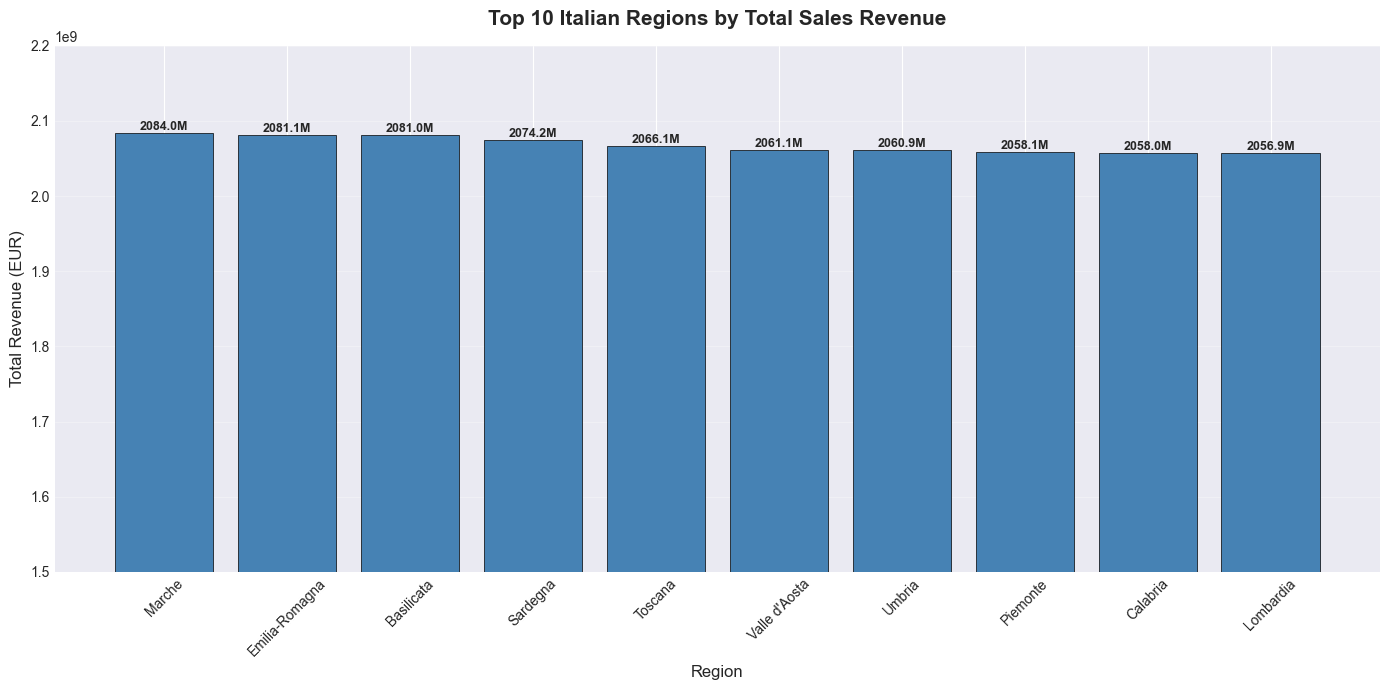

Saved: 05_streaming_sales_by_region.png


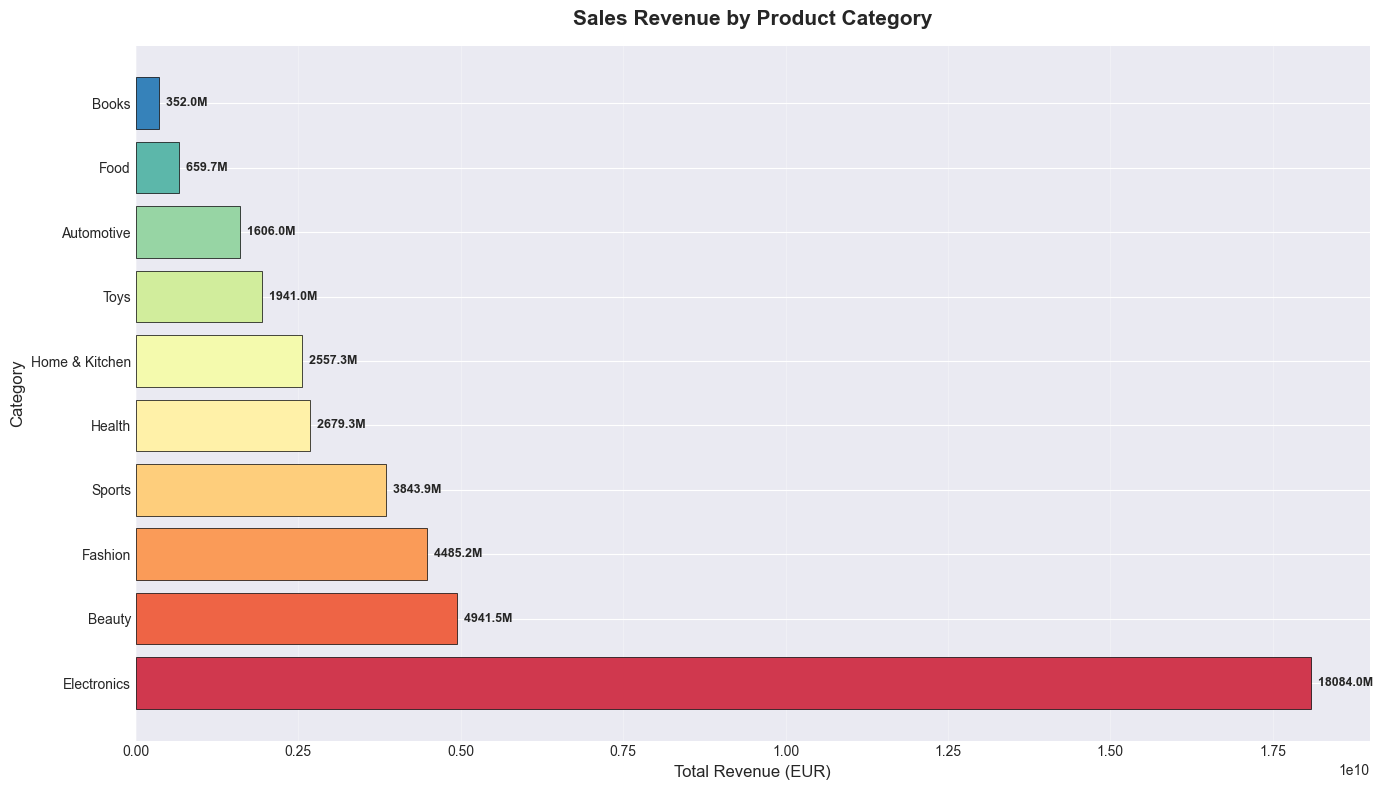

Saved: 05_streaming_sales_by_category.png


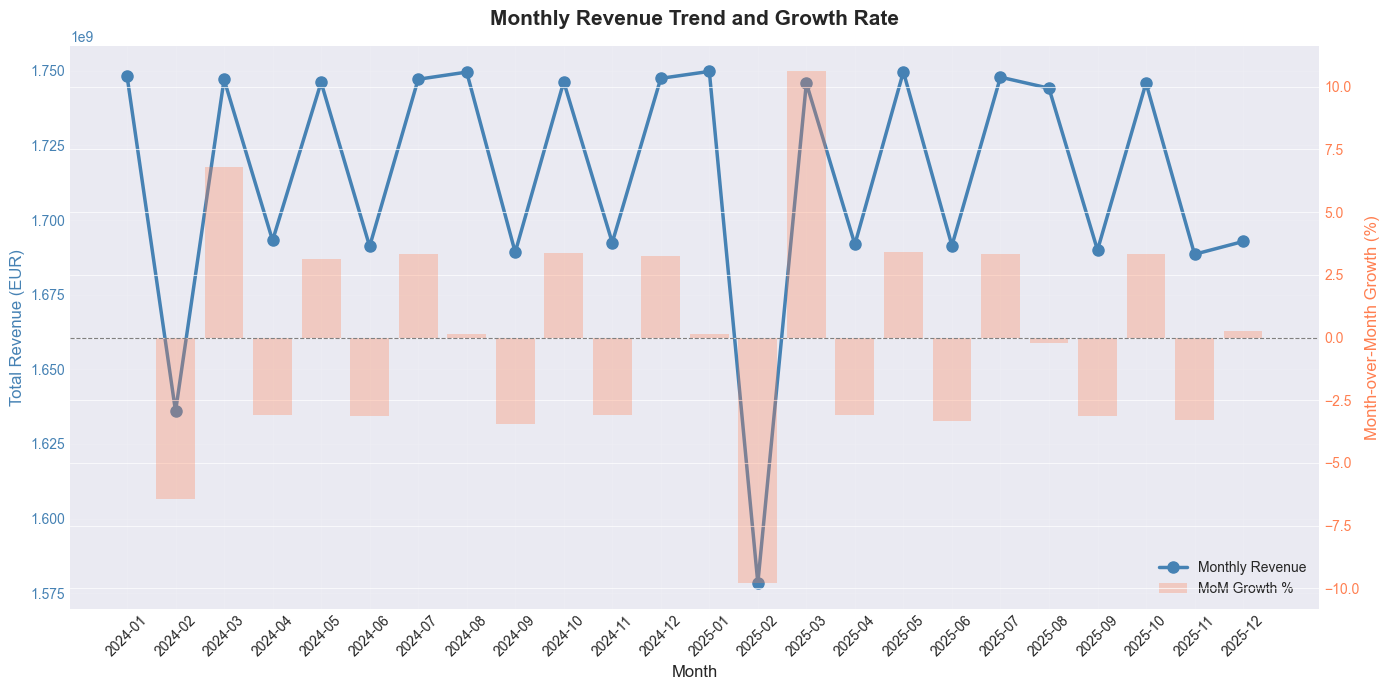

Saved: 05_streaming_daily_trend.png


In [20]:
# INSIGHT VISUALIZATION

# Convert Gold tables to Pandas
region_pd = spark.read.format("delta").load(GOLD_REGION_PATH).toPandas()
category_pd = spark.read.format("delta").load(GOLD_CATEGORY_PATH).toPandas()
trend_pd = spark.read.format("delta").load(GOLD_TREND_PATH).toPandas()

# Sort for visualization
region_pd = region_pd.sort_values("total_revenue", ascending=False)
category_pd = category_pd.sort_values("total_revenue", ascending=False)
trend_pd = trend_pd.sort_values("year_month")

print("Gold tables converted to Pandas:")
print(f"  Region:   {len(region_pd)} rows")
print(f"  Category: {len(category_pd)} rows")
print(f"  Trend:    {len(trend_pd)} rows")


#  Chart 1: Total Sales by Region 
fig, ax = plt.subplots(figsize=(14, 7))

top_regions = region_pd.head(TOP_N_REGIONS)
bars = ax.bar(
    top_regions["region"],
    top_regions["total_revenue"],
    color="steelblue",
    edgecolor="black",
    linewidth=0.5
)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2., height,
        f"{height/1e6:.1f}M",
        ha="center", va="bottom", fontsize=9, fontweight="bold"
    )

ax.set_title(
    f"Top {TOP_N_REGIONS} Italian Regions by Total Sales Revenue",
    fontsize=15, fontweight="bold", pad=15
)
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Total Revenue (EUR)", fontsize=12)
ax.set_ylim(1.5*1e9, 2.2*1e9)
ax.tick_params(axis="x", rotation=45)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
chart_path = GRAPH_DIR / "05_streaming_sales_by_region.png"
plt.savefig(chart_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: 05_streaming_sales_by_region.png")


# Chart 2: Sales by Product Category
fig, ax = plt.subplots(figsize=(14, 8))

colors = sns.color_palette("Spectral", n_colors=len(category_pd))
bars = ax.barh(
    category_pd["category"],
    category_pd["total_revenue"],
    color=colors,
    edgecolor="black",
    linewidth=0.5
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(
        width, bar.get_y() + bar.get_height() / 2.,
        f"  {width/1e6:.1f}M",
        ha="left", va="center", fontsize=9, fontweight="bold"
    )

ax.set_title(
    "Sales Revenue by Product Category",
    fontsize=15, fontweight="bold", pad=15
)
ax.set_xlabel("Total Revenue (EUR)", fontsize=12)
ax.set_ylabel("Category", fontsize=12)
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
chart_path = GRAPH_DIR / "05_streaming_sales_by_category.png"
plt.savefig(chart_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: 05_streaming_sales_by_category.png")


# Chart 3: Monthly Revenue Trend with Growth Rate

fig, ax1 = plt.subplots(figsize=(14, 7))

# Revenue line
color_revenue = "steelblue"
ax1.plot(
    trend_pd["year_month"], trend_pd["total_revenue"],
    marker="o", linewidth=2.5, markersize=8,
    color=color_revenue, label="Monthly Revenue"
)
ax1.set_xlabel("Month", fontsize=12)
ax1.set_ylabel("Total Revenue (EUR)", fontsize=12, color=color_revenue)
ax1.tick_params(axis="y", labelcolor=color_revenue)
ax1.tick_params(axis="x", rotation=45)

# Growth rate on secondary axis
ax2 = ax1.twinx()
color_growth = "coral"
growth_data = trend_pd.dropna(subset=["growth_rate_pct"])
ax2.bar(
    growth_data["year_month"], growth_data["growth_rate_pct"],
    alpha=0.3, color=color_growth, label="MoM Growth %"
)
ax2.set_ylabel("Month-over-Month Growth (%)", fontsize=12, color=color_growth)
ax2.tick_params(axis="y", labelcolor=color_growth)
ax2.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)

ax1.set_title(
    "Monthly Revenue Trend and Growth Rate",
    fontsize=15, fontweight="bold", pad=15
)

ax1.grid(alpha=0.1)
ax2.grid(alpha=0.7)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

plt.tight_layout()
chart_path = GRAPH_DIR / "05_streaming_daily_trend.png"
plt.savefig(chart_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: 05_streaming_daily_trend.png")

In [21]:
# EXPORT CSV RESULTS

region_pd.to_csv(RESULTS_DIR / "05_streaming_sales_by_region.csv", index=False)
category_pd.to_csv(RESULTS_DIR / "05_streaming_sales_by_category.csv", index=False)
trend_pd.to_csv(RESULTS_DIR / "05_streaming_daily_trend.csv", index=False)

print("CSV files exported:")
print(f"  05_streaming_sales_by_region.csv")
print(f"  05_streaming_sales_by_category.csv")
print(f"  05_streaming_daily_trend.csv")

CSV files exported:
  05_streaming_sales_by_region.csv
  05_streaming_sales_by_category.csv
  05_streaming_daily_trend.csv


In [22]:
# CLEANUP

# Stop Spark session
print("\nStopping Spark session...")
spark.stop()
print("  Spark session stopped.")


Stopping Spark session...
  Spark session stopped.
